# Build a Customer Churn Model for Music Streaming App Users

In this demo, you are going to learn how to use various SageMaker functionalities to build, train, and deploy the model from end to end, including data pre-processing steps like ingestion, cleaning and processing, feature engineering, training and hyperparameter tuning, model explainability, and eventually deploy the model. There are two parts of the demo: in part 1: Prepare Data, you will process the data with the help of Data Wrangler, then create features from the cleaned data. By the end of part 1, you will have a complete feature data set that contains all attributes built for each user, and it is ready for modeling. Then in part 2: Modeling and Reference, you will use the data set built from part 1 to find an optimal model for the use case, then test the model predictability with the test data. To start with Part 2, you can either read in data from the output of your Part 1 results, or use the provided 'data/full_feature_data.csv' as the input for the next steps.


For how to set up the SageMaker Studio Notebook environment, please check the [onboarding video]( https://www.youtube.com/watch?v=wiDHCWVrjCU&feature=youtu.be). And for a list of services covered in the use case demo, please check the documentation linked in each section.


## Content
* [Overview](#Overview)
* [Data Selection](#2)
* [Ingest Data](#4)
* [Data Cleaning and Data Exploration](#5)
* [Pre-processing with SageMaker Data Wrangler](#7)
* [Feature Engineering with SageMaker Processing](#6)
* [Data Splitting](#8)
* [Model Selection](#9)
* [Training with SageMaker Estimator and Experiment](#10)
* [Hyperparameter Tuning with SageMaker Hyperparameter Tuning Job](#11)
* [Deploy the model with SageMaker Batch-transform](#12)
* [Model Explainability with SageMaker Clarify](#15)
* [Optional: Automate your training and model selection with SageMaker Autopilot (Console)](#13)

## Overview
### What is Customer Churn and why is it important for businesses?
Customer churn, or customer retention/attrition, means a customer has the tendency to leave and stop paying for a business. It is one of the primary metrics companies want to track to get a sense of their customer satisfaction, especially for a subscription-based business model. The company can track churn rate (defined as the percentage of customers churned during a period) as a health indicator for the business, but we would love to identify the at-risk customers before they churn and offer appropriate treatment to keep them with the business, and this is where machine learning comes into play.
### Use Cases for Customer Churn
Any subscription-based business would track customer churn as one of the most critical Key Performance Indicators (KPIs). Such companies and industries include Telecom companies (cable, cell phone, internet, etc.), digital subscriptions of media (news, forums, blogposts platforms, etc.), music and video streaming services, and other Software as a Service (SaaS) providers (e-commerce, CRM, Mar-Tech, cloud computing, video conference provider, and visualization and data science tools, etc.)
### Define Business problem
To start with, here are some common business problems to consider depending on your specific use cases and your focus:
 * Will this customer churn (cancel the plan, cancel the subscription)?
 * Will this customer downgrade a pricing plan?
 * For a subscription business model, will a customer renew his/her subscription?

### Machine learning problem formulation
#### Classification: will this customer churn?
To goal of classification is to identify the at-risk customers and sometimes their unusual behavior, such as: will this customer churn or downgrade their plan? Is there any unusual behavior for a customer? The latter question can be formulated as an anomaly detection problem.
#### Time Series: will this customer churn in the next X months? When will this customer churn?
You can further explore your users by formulating the problem as a time series one and detect when will the customer churn.

### Data Requirements
#### Data collection Sources
Some most common data sources used to construct a data set for churn analysis are:
* Customer Relationship Management platform (CRM), 
* engagement and usage data (analytics services), 
* passive feedback (ratings based on your request), and active feedback (customer support request, feedback on social media and review platforms).

#### Construct a Data Set for Churn Analysis
Most raw data collected from the sources mentioned above are huge and often needs a lot of cleaning and pre-processing. For example, usage data is usually event-based log data and can be more than a few gigabytes every day; you can aggregate the data to user-level daily for further analysis. Feedback and review data are mostly text data, so you would need to clean and pre-process the natural language data to be normalized, machine-readable data. If you are joining multiple data sources (especially from different platforms) together, you would want to make sure all data points are consistent, and the user identity can be matched across different platforms.
           
#### Challenges with Customer Churn
* Business related
    * Importance of domain knowledge: this is critical when you start building features for the machine learning model. It is important to understand the business enough to decide which features would trigger retention.
* Data issues
    * fewer churn data available (imbalanced classes): data for churn analysis is often very imbalanced as most of the customers of a business are happy customers (usually).
    * User identity mapping problem: if you are joining data from different platforms (CRM, email, feedback, mobile app, and website usage data), you would want to make sure user A is recognized as the same user across multiple platforms. There are third-party solutions that help you tackle this problem.
    * Not collecting the right data for the use case or Lacking enough data

# Use Case Study - Music Streaming User Churn Prediction
<a id='2'></a>
## Data Selection
You will use generated music streaming data that is simulated to imitate music streaming user behaviors. The data simulated contains 1100 users and their user behavior for one year (2019/10/28 - 2020/10/28). Data is simulated using the [EventSim](https://github.com/Interana/eventsim) and does not contain any real user data.
* Observation window: you will use 1 year of data to generate predictions.
* Explanation of fields:
    * `ts`: event UNIX timestamp
    * `userId`: a randomly assigned unique user id
    * `sessionId`: a randomly assigned session id unique to each user
    * `page`: event taken by the user, e.g. "next song", "upgrade", "cancel"
    * `auth`: whether the user is a logged-in user
    * `method`: request method, GET or PUT
    * `status`: request status
    * `level`: if the user is a free or paid user
    * `itemInSession`: event happened in the session
    * `location`: location of the user's IP address
    * `userAgent`: agent of the user's device
    * `lastName`: user's last name
    * `firstName`: user's first name
    * `registration`: user's time of registration
    * `gender`: gender of the user
    * `artist`: artist of the song the user is playing at the event
    * `song`: song title the user is playing at the event
    * `length`: length of the session
 
 
 * the data will be downloaded from Github and contained in an [_Amazon Simple Storage Service_](https://aws.amazon.com/s3/) (Amazon S3) bucket.

For this specific use case, you will focus on a solution to predict whether a customer will cancel the subscription. Some possible expansion of the work includes:
* predict plan downgrading
* when a user will churn
* add song attributes (genre, playlist, charts) and user attributes (demographics) to the data
* add user feedback and customer service requests to the data


## Architecture Diagram

The services covered in the use case and an architecture diagram is shown below.

<div>
    <img src="image/use_case_diagram_v2.png" width="800"/>

</div>

# PART 1: Prepare Data

## Set Up Notebook

In [53]:
%pip install -q 'sagemaker==2.19.0' 'botocore == 1.19.33' 's3fs==0.4.2' 'sagemaker-experiments'
#s3fs is needed for pandas to read files from S3

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sagemaker
import json
import pandas as pd
import glob 
import s3fs
import boto3

## Parameters 
The following lists configurable parameters that are used throughout the whole notebook.

In [5]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket() #replace with your own bucket name if you have one
s3 = sagemaker_session.boto_session.resource('s3')

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client('sagemaker')


prefix = 'music-streaming'

<a id='4'></a>
## Ingest Data
We will ingest the simulated data from GitHub (currently in GitHub, can host the data somewhere else if necessary). You can follow the Getting Start Guide[link to the guide] to clone the repository, or open a terminal from **Launcher**, then run the following code:

`git clone https://github.com/ZoeMa/music-streaming.git`

The data is located in the data/folder as zip files. You will unzip the files and upload the files to our S3 bucket.

In [3]:
# unzip the partitioned data files into the same folder
!unzip -o data/simu-1.zip -d data/raw
!unzip -o data/simu-2.zip -d data/raw
!unzip -o data/simu-3.zip -d data/raw
!unzip -o data/simu-4.zip -d data/raw

Archive:  data/simu-1.zip
  inflating: data/simu-1.json        
Archive:  data/simu-2.zip
  inflating: data/simu-2.json        
Archive:  data/simu-3.zip
  inflating: data/simu-3.json        


In [56]:
!unzip -o data/sample.zip -d data/raw

Archive:  data/sample.zip
  inflating: data/raw/sample.json    


In [58]:
!aws s3 cp  ./data/raw s3://$bucket/$prefix/data/json/  --recursive

upload: data/raw/sample.json to s3://sagemaker-us-east-2-060356833389/music-streaming/data/json/sample.json


<a id='5'></a>
## Data Cleaning
Due to the size of the data (~2GB), you will start exploring our data starting with a smaller sample, decide which pre-processing steps are necessary, and apply them to the whole dataset.

In [6]:
import os
# if your SageMaker Studio notebook's memory is getting full, you can run the following command to remove the raw data files from the instance and free up some memory. 
# You will read data from your S3 bucket onwards and will not need the raw data stored in the instance.
#os.remove("data/raw/simu-1.json")
#os.remove("data/raw/simu-2.json")
#os.remove("data/raw/simu-3.json")
#os.remove("data/raw/simu-4.json")
#os.remove("data/simu-1.zip")

In [59]:
sample_file_name = "data/raw/sample.json"
#s3_sample_file_name =  "data/json/sample.json"
#sample_path = "s3://{}/{}/{}".format(bucket, prefix, s3_sample_file_name)
sample = pd.read_json(sample_file_name, lines = True)

In [8]:
sample.head(2)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1592146267731,12065,118,NextSong,Logged In,PUT,200,paid,0,"Richmond, VA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Davis,Bristol,1.591971e+12,M,Peter Tosh,Wanted Dread And Alive (2002 Digital Remaster),267.85914
1,1592146268731,12065,118,Thumbs Down,Logged In,PUT,307,paid,1,"Richmond, VA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Davis,Bristol,1.591971e+12,M,NaN,NaN,NaN


#### Remove irrelevant columns
From the first look of data, you can notice that columns `lastName`, `firstName`, `method` and `status` are not relevant features. These will be dropped from the data.

In [9]:
columns_to_remove = ['method', 'status', 'lastName', 'firstName']
sample = sample.drop(columns = columns_to_remove)

#### Check for null values
You are going to remove all events without an `userId` assigned since you are predicting which recognized user will churn from our service. In this case, all the rows(events) have a `userId` and `sessionId` assigned, but you will still run this step for the full dataset. For other columns, there are ~3% of data that are missing some demographic information of the users, and ~20% missing the song attributes, which is because the events contain not only playing a song, but also other actions including login and log out, downgrade, cancellation, etc. There are ~3% of users that do not have a registration time, so you will remove these anonymous users from the record.

In [10]:
print ('percentage of the value missing in each column is: ')
sample.isnull().sum() / len(sample)

percentage of the value missing in each column is: 


ts               0.000000
userId           0.000000
sessionId        0.000000
page             0.000000
auth             0.000000
level            0.000000
itemInSession    0.000000
location         0.025447
userAgent        0.025447
registration     0.025447
gender           0.025447
artist           0.210330
song             0.210330
length           0.210330
dtype: float64

In [11]:
sample = sample[~sample['userId'].isnull()]
sample = sample[~sample['registration'].isnull()]

## Data Exploration
Let's take a look at our categorical columns first: `page`, `auth`, `level`, `location`, `userAgent`, `gender`, `artist`, and `song`, and start with looking at unique values for `page`, `auth`, `level`, and `gender` since the other three have many unique values and you will take a different approach.

In [12]:
cat_columns = ['page', 'auth', 'level',  'gender']
cat_columns_long = ['location', 'userAgent', 'artist', 'song', 'userId']
for col in cat_columns:
    print( "The unique values in column {} are: {}".format(col, sample[col].unique()))
for col in cat_columns_long:
    print ( "There are {} unique values  in column {}".format(sample[col].nunique(), col))

The unique values in column page are: ['NextSong' 'Thumbs Down' 'Home' 'Settings' 'Thumbs Up' 'Add to Playlist'
 'Roll Advert' 'Save Settings' 'Help' 'Logout' 'Add Friend' 'Downgrade'
 'About' 'Upgrade' 'Error' 'Submit Upgrade' 'Submit Downgrade' 'Cancel'
 'Cancellation Confirmation']
The unique values in column auth are: ['Logged In' 'Cancelled']
The unique values in column level are: ['paid' 'free']
The unique values in column gender are: ['M' 'F']
There are 72 unique values  in column location
There are 37 unique values  in column userAgent
There are 16207 unique values  in column artist
There are 51447 unique values  in column song
There are 101 unique values  in column userId


#### Key observations from the above information
* There are 101 unique users with 72 unique locations, this information may not be useful as a categorical feature. You can parse this field and only keep State information, but even that will give us 50 unique values in this category, so you can either remove this column or bucket it to a higher level (NY --> Northeast).
* Artist and song details might not be helpful as categorical features as there are too many categories; you can quantify these to a user level, i.e. how many artists this user has listened to in total, how many songs this user has played in the last week, last month, in 180 days, in 365 days. You can also bring in external data to get song genres and other artist attributes to enrich this feature.
* In the column `page`,  'Thumbs Down', 'Thumbs Up', 'Add to Playlist', 'Roll Advert','Help', 'Add Friend', 'Downgrade', 'Upgrade', and 'Error' can all be great features to churn analysis. You will aggregate them to user-level later. There is a "cancellation confirmation" value that can be used for the churn indicator.

* Let's take a look at the column `userAgent`:


UserAgent contains little useful information, but if you care about the browser type and mac/windows difference, you can parse the text and extract the information. Sometimes businesses would love to analyze user behavior based on their App version and device type (iOS v.s. Android), so these could be useful information. In this use case, for modeling purpose, we will remove this column. but you can keep it as a filter for data visualization.

In [13]:
columns_to_remove = ['location', 'userAgent']
sample = sample.drop(columns = columns_to_remove)

Let's take a closer look at the timestamp columns `ts` and `registration`. We can convert the event timestamp `ts` to year, month, week, day, day of the week, and hour of the day. The registration time should be the same for the same user, so we can aggregate this value to user-level and create a time delta column to calculate the time between registration and the newest event.

In [14]:
sample['date'] = pd.to_datetime(sample['ts'],unit='ms')
sample['ts_year'] = sample['date'].dt.year
sample['ts_month'] = sample['date'].dt.month
sample['ts_week'] = sample['date'].dt.week
sample['ts_day'] = sample['date'].dt.day
sample['ts_dow'] = sample['date'].dt.weekday
sample['ts_hour'] = sample['date'].dt.hour
sample['ts_date_day'] = sample['date'].dt.date
sample['ts_is_weekday'] = [1  if x in [0,1,2,3,4] else 0 for x in sample['ts_dow']]
sample['registration_ts'] = pd.to_datetime(sample['registration'],unit='ms').dt.date

#### Define Churn
In this use case, you will use `page == "Cancellation Confirmation"` as the indicator of a user churn. You can also use `page == 'downgrade` if you are interested in users downgrading their payment plan. There are ~13% users churned, so you will need to up-sample or down-sample the full dataset to deal with the imbalanced class, or carefully choose your algorithms.

In [15]:
print ('There are {:.2f}% of users churned in this dataset'.format(((sample[sample['page'] == 'Cancellation Confirmation']['userId'].nunique())/sample['userId'].nunique())*100))

There are 12.87% of users churned in this dataset


You can label a user by adding a churn label at a event level then aggregate this value to user level. 

In [16]:
sample['churned_event'] = [1 if x == 'Cancellation Confirmation' else 0 for x in sample['page']]
sample['user_churned'] = sample.groupby('userId')['churned_event'].transform('max')

#### Imbalanced Class
Imbalanced class (much more positive cases than negative cases) is very common in churn analysis. It can be misleading for some machine learning model as the accuracy will be biased towards the majority class. Some useful tactics to deal with imbalanced class are [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html), use algorithms that are less sensitive to imbalanced class like a tree-based algorithm or use a cost-sensitive algorithm that penalizes wrongly classified minority class.

To Summarize every pre-processing steps you have covered:
* null removals
* drop irrelevant columns
* convert event timestamps to features used for analysis and modeling: year, month, week, day, day of week, hour, date, if the day is weekday or weekend, and convert registration timestamp to UTC.
* create labels (whether the user churned eventually), which is calculated by if one churn event happened in the user's history, you can label the user as a churned user (1). 

#### Exploring Data
Based on the available data, look at every column, and decide if you can create a feature from it. For all the columns, here are some directions to explore:

    * `ts`: distribution of activity time: time of the day, day of the week
    * `sessionId`: average number of sessions per user
    * `page`:  number of thumbs up/thumbs down, added to the playlist, ads, add friend, if the user has downgrade or upgrade the plan, how many errors the user has encountered.
    * `level`: if the user is a free or paid user
    * `registration`: days the user being active, time the user joined the service
    * `gender`: gender of the user
    * `artist`: average number of artists the user listened to
    * `song`: average number of songs listened per user
    * `length`: average time spent per day per user
   
**Activity Time**

1. Weekday v.s. weekend trends for churned users and active users. It seems like churned users are more active on weekdays than weekends whereas active users do not show a strong difference between weekday v.s. weekends. You can create some features from here: for each user, average events per day -- weekends, average events per day -- weekdays. You can also create features - average events per day of the week, but that will be converted to 7 features after one-hot-encoding, which may be less informative than the previous method.
2. In terms of hours active during a day, our simulated data did not show a significant difference between day and night for both sets of users. You can have it on your checklist for your analysis, and similarly for the day of the month, the month of the year when you have more than a year of data.

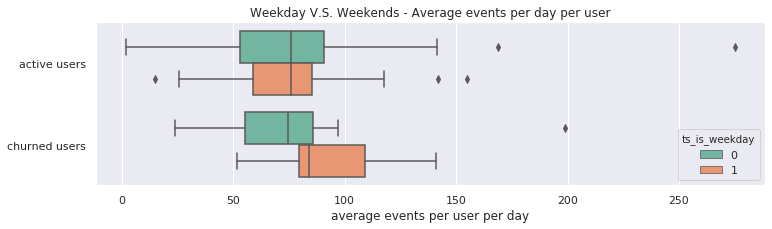

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

events_per_day_per_user = sample.groupby(['userId', 'ts_date_day', 'ts_is_weekday', 'user_churned']).agg({'page': 'count'}).reset_index()
events_dist = events_per_day_per_user.groupby(['userId','ts_is_weekday', 'user_churned']).agg({'page': 'mean'}).reset_index()

def trend_plot(df, plot_type, x, y,hue = None, title =None, x_axis = None, y_axis = None, xticks = None, yticks = None):
    if plot_type == 'box':
        fig =  sns.boxplot(x= 'page', y = y, data = df, hue = hue, orient="h")
    elif plot_type == 'bar':
        fig = sns.barplot(x= x, y = y, data = df, hue = hue)
        
    sns.set(rc={'figure.figsize':(12,3)})
    sns.set_palette("Set2")
    sns.set_style("darkgrid")
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.yticks([0,1],yticks)
    return plt.show(fig)

trend_plot(events_dist, 'box', 'page', 'user_churned', 'ts_is_weekday',
         'Weekday V.S. Weekends - Average events per day per user', 'average events per user per day', 
        yticks = ['active users', 'churned users'])

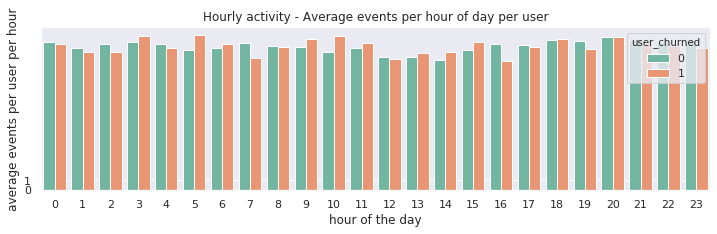

In [20]:
events_per_hour_per_user = sample.groupby(['userId', 'ts_date_day','ts_hour',  'user_churned']).agg({'page': 'count'}).reset_index()
events_dist = events_per_hour_per_user.groupby(['userId','ts_hour', 'user_churned']).agg({'page': 'mean'}).reset_index().groupby(['ts_hour', 'user_churned']).agg({'page': 'mean'}).reset_index()
trend_plot(events_dist, 'bar', 'ts_hour', 'page', 'user_churned',
         'Hourly activity - Average events per hour of day per user', 'hour of the day', 'average events per user per hour')

**Listening Behavior**

You can look at some basic stats for a user's listening habits. Churned users generally listen to a wider variety of songs and artists and spend more time on the App/be with the App longer.
* Average total: number of sessions, App usage length, number of songs listened, number of artists listened per user, number of ad days active
* Average daily: number of sessions, App usage length, number of songs listened, number of artists listened per user


In [21]:
stats_per_user = sample.groupby(['userId', 'user_churned']).agg({"sessionId": 'count',
                                                                  'song':'nunique',
                                                                  'artist': 'nunique',
                                                                  'length': 'sum',
                                                                'ts_date_day': 'count'}).reset_index()
avg_stats_group = stats_per_user.groupby(['user_churned']).agg({"sessionId": 'mean',
                                                                   'song':'mean',
                                                                  'artist': 'mean',
                                                                  'length': 'mean',
                                                                'ts_date_day': 'mean'
                                                               }).reset_index()

print('Average total: number of sessions, App usage length, number of songs listened, number of artists listened per user, days active: ')
avg_stats_group

Average total: number of sessions, App usage length, number of songs listened, number of artists listened per user, days active: 


,user_churned,sessionId,song,artist,length,ts_date_day
0,0,2044.636364,1434.102273,1067.602273,412310.642096,2044.636364
1,1,3260.384615,2173.153846,1493.230769,656340.586522,3260.384615


In [22]:
stats_per_user = sample.groupby(['userId','ts_date_day', 'user_churned']).agg({"sessionId": 'count',
                                                                  'song':'nunique',
                                                                  'artist': 'nunique',
                                                                  'length': 'sum'}).reset_index()
avg_stats_group = stats_per_user.groupby(['user_churned']).agg({"sessionId": 'mean',
                                                                   'song':'mean',
                                                                  'artist': 'mean',
                                                                  'length': 'mean'}).reset_index()
print('Average daily: number of sessions, App usage length, number of songs listened, number of artists listened per user: ')
avg_stats_group

Average daily: number of sessions, App usage length, number of songs listened, number of artists listened per user: 


,user_churned,sessionId,song,artist,length
0,0,76.597701,61.301831,59.323116,15446.290551
1,1,92.746171,74.291028,71.501094,18670.519967


**App Usage Behavior**

You can further explore how the users are using the App besides just listening: number of thumbs up/thumbs down, added to playlist, ads, add friend, if the user has downgrade or upgrade the plan, how many errors the user has encountered. Churned users are slightly more active than other users, and also encounter more errors, listened to more ads, and more downgrade and upgrade. These can be numerical features (number of total events per type per user), or more advanced time series numerical features (errors in last 7 days, errors in last month, etc.).

In [23]:
events_list = [ 'NextSong', 'Thumbs Down', 'Thumbs Up', 'Add to Playlist', 'Roll Advert','Add Friend', 'Downgrade',
               'Upgrade', 'Error']
usage_column_name = []
for event in events_list:
    event_name = "_".join(event.split()).lower()
    usage_column_name.append(event_name)
    sample[event_name] =  [1 if x == event else 0 for x in sample['page']]

In [24]:
app_use_per_user =  sample.groupby(['userId','user_churned'])[usage_column_name].sum().reset_index()

In [25]:
app_use_group = app_use_per_user.groupby(['user_churned'])[usage_column_name].mean().reset_index()
app_use_group

,user_churned,nextsong,thumbs_down,thumbs_up,add_to_playlist,roll_advert,add_friend,downgrade,upgrade,error
0,0,1656.204545,16.988636,150.477273,50.863636,7.613636,29.181818,9.568182,1.954545,2.193182
1,1,2645.538462,28.076923,239.615385,80.846154,10.923077,48.923077,12.615385,2.461538,3.461538


<a id='7'></a>
## Pre-processing with SageMaker Data Wrangler

Now that you have a good understanding of your data and decided which steps are needed to pre-process your data, you can utilize the new Amazon SageMaker GUI tool **Data Wrangler**, without writing all the code for the SageMaker Processing Job.

* Here we used a Processing Job to convert the raw streaming data files downloaded from the github repo (`simu-*.zip` files) to a full, CSV formatted file for Data Wrangler Ingestion purpose.
you are importing the raw streaming data files downloaded from the github repo (`simu-*.zip` files). The raw JSON files were converted to CSV format and combined to one file for Data Wrangler Ingestion purpose.

In [ ]:
%%writefile preprocessing_predw.py

import argparse
import os
import warnings
import glob
import time
import pandas as pd
import json

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
start_time = time.time()

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    df_all = pd.DataFrame() 
    for name in glob.glob('/opt/ml/processing/input/[!code]*'):
        print('\nstarting file: {}'.format(name))
        df = pd.read_json(name, lines = True)
        df_all = df_all.append(df)
    final_features_output_path = os.path.join('/opt/ml/processing/output', 'full_data.csv')    
    print('Saving processed data to {}'.format(final_features_output_path))
    df_all.to_csv(final_features_output_path, header=True, index=False)

In [ ]:
input_data_raw = 's3://sagemaker-us-east-2-060356833389/music-streaming/data/json'

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(code='preprocessing_predw.py',
                      inputs=[ProcessingInput(
                        source=input_data_raw,
                          s3_data_type = "S3Prefix",
                         # s3_input_mode = "Pipe",
                        #  s3_compression_type = "Gzip",
                        destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='processed_data',
                                                source='/opt/ml/processing/output')]
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

Now you can initiate a Data Wrangler flow. An example flow (`dw_example.flow`) is provided in the github repo. 

From the SageMaker Studio launcher page, choose **New data flow**, then choose **import from S3**. 

<div>
<img src="image/mo1.PNG" width="600"/>
   </div>
   
You can import any .csv format file with SageMaker Data Wrangler, preview your data, and decide what pre-processing steps are needed.
  <div>
<img src="image/mo2.PNG" width="600"/>
   </div> 
You can choose your pre-processing steps, including drop columns and rename columns from the pre-built solutions, also customize processing and feature engineering code in the custom Pandas code block.
<div>
<img src="image/mo3.PNG" width="600"/>

</div>
After everything run through, it will create a Processing job notebook for you. You can run through the notebook to kick off the Processing Job and check the status in the console.

<div>
<img src="image/mo4.PNG" width="600"/>

</div>

#### Find the data path of the SageMaker Data Wrangler Job
You can get the results from your Data Wrangler Job, check the results, and use it as input for your feature engineering processing job.

In [7]:
### if you see an "not exist" error running this cell, go back to the Data Wrangler Job and run the storemagic cell to save the output variable. 
#%store -r
#output_prefix

'export-flow-02-19-27-21-72a11d3c/output'

In [26]:
s3_client = boto3.client("s3")
list_response = s3_client.list_objects_v2(Bucket=bucket, Prefix = 'export-flow')

data_wrangler_output_path = None

In [27]:
for content in list_response["Contents"]:
    if "_SUCCESS" not in content["Key"]:
        data_wrangler_output_path = content["Key"]

print(data_wrangler_output_path)

export-flow-02-19-27-21-72a11d3c/output/data-wrangler-flow-processing-02-19-27-21-72a11d3c/7b74dbbc-6f7e-4656-8f78-25272604bc45/default/part-00000-db6f32ff-8081-4a57-b790-45670cf904ea-c000.csv


In [28]:
s3_data_wrangler_output_path = 's3://{}/{}'.format(bucket, data_wrangler_output_path)
pd.read_csv(s3_data_wrangler_output_path, nrows = 3)

,ts,userId,sessionId,page,auth,level,itemInSession,registration,gender,artist,song,length
0,1592146267731,12065,118,NextSong,Logged In,paid,0,1.591971e+12,M,Peter Tosh,Wanted Dread And Alive (2002 Digital Remaster),267.0
1,1592146268731,12065,118,Thumbs Down,Logged In,paid,1,1.591971e+12,M,NaN,NaN,NaN
2,1592146534731,12065,118,NextSong,Logged In,paid,2,1.591971e+12,M,Jimmy Eat World,The Middle,166.0


In [213]:
## The output from Data Wrangler is also provided in the github repo (data/data_wrangler_output.csv). 
## You can also read the provided csv directly.

<a id='6'></a>
## Feature engineering with SageMaker Processing Job


For user churn analysis, usually, you can consider build features from the following aspects:

* Generate base features:
     * user behavior features (listening behavior, app behavior).
     * customer demographic features.
     * customer support features (interactions, ratings, etc.)
* Formulate time series as features:
    * construct streaming time as time series.
    * build features in the different time windows (e.g. total songs listened in the last 7 days, 30 days, 180 days, etc.)
   
For this use case, after exploring the data and with all the findings you gathered, now is the time to create features used for your model. Since the data set is time series, you can enrich your features by adding a time factor to it: e.g., for the total number of songs listened, you can create features like total songs listened in the last 7 days, last 30 days, last 90 days, last 180 days, etc. The features built for these use cases will be at the user level - each row represents one user, and will include the following:

* daily features:
     * average_events_weekday (numerical): average number of events per day during weekday
     * average_events_weekend (numerical): average number of events per day during the weekend
     * num_ads_7d: number of ads in last 7 days
     * num_error_7d: total errors encountered in last 7 days
     * num_songs_played_7d: total songs played in last 7 days
     * num_songs_played_30d: total songs played in last 30 days
     * num_songs_played_90d: total songs played in last 90 days
* user features:
     * num_artists (numerical): number of artists the user has listened to
     * num_songs (numerical): number of songs played
     * num_ads (numerical): number of ads played
     * num_thumbsup (numerical): number of times the user likes a song
     * num_thumbsdown (numerical): number of times the user dislikes a song
     * num_playlist (numerical): number of times user adds a song to a playlist
     * num_addfriend (numerical): number of times user adds a friend
     * num_error (numerical): number of times user encountered an error
     * user_downgrade (binary): user has downgraded plan
     * user_upgrade (binary): user has upgraded plan
     * percentage_song: percentage of the user's action is 'NextSong' (only listens to songs) 
     * percentage_ad: percentage of the user's action is 'Roll Advert'
     * repeats_ratio: percentage of total songs that are repeats
     * days_since_active: days since the user registered and leave (if the user cancels)
* Session features:
     * num_sessions: number of total sessions
     * avg_time_per_session: average time spent per session
     * avg_events_per_session: average number of events per session
     * avg_gap_between_session: average time between sessions
   
The following function will create the processing job with SageMaker Processing, a new Python SDK that lets data scientists and ML engineers easily run preprocessing, postprocessing and model evaluation workloads on Amazon SageMaker. This SDK uses SageMaker’s built-in container for scikit-learn, possibly the most popular library for data set transformation.
You can find a complete guide to the SageMaker Processing job in [this blog](https://aws.amazon.com/blogs/aws/amazon-sagemaker-processing-fully-managed-data-processing-and-model-evaluation/).

In [29]:
from sagemaker.sklearn.processing import SKLearnProcessor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.m5.xlarge',
                                     instance_count=1)

#### Replace the data path file name with your data wrangler output name as below

In [30]:
data_wrangler_output_name = s3_data_wrangler_output_path.split('/')[-1]

In [31]:
### REPLACE THE INPUT FILE NAME WITH THE FOLLOWING NAME
data_wrangler_output_name

'part-00000-db6f32ff-8081-4a57-b790-45670cf904ea-c000.csv'

In [32]:
### SAVE THE OUTPUT FILE NAME FROM PROCESSING JOB 
processing_job_output_name = 'processing_job_output.csv'
%store processing_job_output_name

Stored 'processing_job_output_name' (str)


In [37]:
%%writefile preprocessing.py

import os
import warnings
import time
import pandas as pd
import argparse
#from sklearn.exceptions import DataConversionWarning
#warnings.filterwarnings(action='ignore', category=DataConversionWarning)
start_time = time.time()

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dw-output-path')
    
    args, _ = parser.parse_known_args()
    print('Received arguments {}'.format(args))

    dw_output_name = args.dw_output_path
    data_path = os.path.join('/opt/ml/processing/input', dw_output_name)
    df = pd.read_csv(data_path)
    ## convert to time
    df['date'] = pd.to_datetime(df['ts'],unit='ms')
    df['ts_dow'] = df['date'].dt.weekday
    df['ts_date_day'] = df['date'].dt.date
    df['ts_is_weekday'] = [1  if x in [0,1,2,3,4] else 0 for x in df['ts_dow']]
    df['registration_ts'] = pd.to_datetime(df['registration'],unit='ms').dt.date
    ## add labels
    df['churned_event'] = [1 if x == 'Cancellation Confirmation' else 0 for x in df['page']]
    df['user_churned'] = df.groupby('userId')['churned_event'].transform('max') 

    ## convert pages categorical variables to numerical
    events_list = [ 'NextSong', 'Thumbs Down', 'Thumbs Up', 'Add to Playlist', 'Roll Advert','Add Friend', 'Downgrade',
               'Upgrade', 'Error']
    usage_column_name = []
    for event in events_list:
        event_name = "_".join(event.split()).lower()
        usage_column_name.append(event_name)
        df[event_name] =  [1 if x == event else 0 for x in df['page']]
    ## feature engineering
    # average_events_weekday (numerical): average number of events per day during weekday
    # average_events_weekend (numerical): average number of events per day during the weekend
    base_df = df.groupby(['userId',
            'ts_date_day', 
            'ts_is_weekday']).agg({'page': 'count'}).groupby(['userId', 
                                                     'ts_is_weekday'])['page'].mean().unstack(fill_value=0).reset_index().rename(
    columns={0:'average_events_weekend', 1: 'average_events_weekday'})

    #num_ads_7d, num_songs_played_7d, num_songs_played_30d, num_songs_played_90d, num_ads_7d, num_error_7d
    base_df_daily = df.groupby(['userId','ts_date_day']).agg({
        'page': 'count',
        'nextsong':'sum',
        'roll_advert': 'sum', 
        'error': 'sum'
    }).reset_index()
    feature34 = base_df_daily.groupby(['userId', 'ts_date_day']).tail(7).groupby(['userId']).agg({'nextsong':'sum',  'roll_advert': 'sum', 'error': 'sum' }).reset_index().rename(
        columns={'nextsong':'num_songs_played_7d', 'roll_advert': 'num_ads_7d', 'error': 'num_error_7d'})
    feature5 = base_df_daily.groupby(['userId', 'ts_date_day']).tail(30).groupby(['userId']).agg({'nextsong':'sum'}).reset_index().rename(
        columns={'nextsong':'num_songs_played_30d'})
    feature6 = base_df_daily.groupby(['userId', 'ts_date_day']).tail(90).groupby(['userId']).agg({'nextsong':'sum' }).reset_index().rename(
        columns={'nextsong':'num_songs_played_90d'})
    # num_artists, num_songs, num_ads, num_thumbsup, num_thumbsdown, num_playlist, num_addfriend, num_error, user_downgrade, 
    # user_upgrade, percentage_ad, days_since_active
    base_df_user = df.groupby(['userId']).agg({
        'page': 'count',
        'nextsong':'sum',
        'artist': 'nunique',
        'song': 'nunique',
        'thumbs_down': 'sum',
        'thumbs_up': 'sum',
        'add_to_playlist': 'sum',
        'roll_advert': 'sum',
        'add_friend' : 'sum',
        'downgrade': 'max',
        'upgrade': 'max',
        'error': 'sum',
        'ts_date_day': 'max',
        'registration_ts': 'min',
        'user_churned': 'max'
    }).reset_index()
    base_df_user['percentage_ad'] = base_df_user['roll_advert']/base_df_user['page'] 
    base_df_user['days_since_active'] = (base_df_user['ts_date_day'] - base_df_user['registration_ts']).dt.days
    # repeats ratio
    base_df_user['repeats_ratio'] = 1 - base_df_user['song'] /base_df_user['nextsong']     

    #num_sessions, avg_time_per_session, avg_events_per_session, 
    base_df_session = df.groupby(['userId', 'sessionId']).agg({
         'length': 'sum',
        'page':'count',
        'date': 'min'
    }).reset_index()
    base_df_session['prev_session_ts'] = base_df_session.groupby(['userId'])['date'].shift(1)
    base_df_session['gap_session'] = (base_df_session['date'] -  base_df_session['prev_session_ts']).dt.days
    user_sessions = base_df_session.groupby('userId').agg({
        'sessionId': 'count',
         'length': 'mean',
        'page':'mean',
        'gap_session': 'mean'
    }).reset_index().rename(
        columns={'sessionId':'num_sessions', 'length': 'avg_time_per_session', 
                 'page': 'avg_events_per_session', 'gap_session': 'avg_gap_between_session'})

    #merge features together
    base_df['userId'] = base_df['userId'].astype('int')
    final_feature_df = base_df.merge(feature34, how = 'left', on = 'userId')
    final_feature_df = final_feature_df.merge(feature5, how = 'left', on = 'userId')
    final_feature_df = final_feature_df.merge(feature6, how = 'left', on = 'userId')
    final_feature_df = final_feature_df.merge(user_sessions, how = 'left', on = 'userId')
    final_feature_df = final_feature_df.merge(base_df_user, how = 'left', on = 'userId')

    final_feature_df = final_feature_df.fillna(0)
    #renaming columns
    final_feature_df.columns = ['userId', 'average_events_weekend', 'average_events_weekday',
       'num_songs_played_7d', 'num_ads_7d', 'num_error_7d',
       'num_songs_played_30d', 'num_songs_played_90d', 'num_sessions',
       'avg_time_per_session', 'avg_events_per_session',
       'avg_gap_between_session', 'num_events', 'num_songs', 'num_artists', 'num_unique_songs',
       'num_thumbs_down', 'num_thumbs_up', 'num_add_to_playlist', 'num_ads',
       'num_add_friend', 'num_downgrade', 'num_upgrade', 'num_error', 'ts_date_day',
       'registration_ts', 'user_churned', 'percentage_ad', 'days_since_active',
       'repeats_ratio']
    #only keep created feature columns
    final_feature_df = final_feature_df[['userId', 'user_churned', 'average_events_weekend', 'average_events_weekday',
       'num_songs_played_7d', 'num_ads_7d', 'num_error_7d',
       'num_songs_played_30d', 'num_songs_played_90d', 'num_sessions',
       'avg_time_per_session', 'avg_events_per_session',
       'avg_gap_between_session', 'num_events', 'num_songs', 'num_artists', 
       'num_thumbs_down', 'num_thumbs_up', 'num_add_to_playlist', 'num_ads',
       'num_add_friend', 'num_downgrade', 'num_upgrade', 'num_error', 'percentage_ad', 'days_since_active',
       'repeats_ratio']]

    print('shape of file to append:\t\t{}'.format(final_feature_df.shape))
    iter_end_time = time.time()
    end_time = time.time()
    print('minutes elapsed: {}'.format(str((end_time-start_time)/60)))
    ### CHANGE THE OUTPUT FILE NAME WITH YOUR OWN NAME ABOVE
    final_features_output_path = os.path.join('/opt/ml/processing/output', 'processing_job_output.csv')    
    print('Saving processed data to {}'.format(final_features_output_path))
    final_feature_df.to_csv(final_features_output_path, header=True, index=False)

Overwriting preprocessing.py


In [38]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

input_data = s3_data_wrangler_output_path

sklearn_processor.run(code='preprocessing.py',
                      inputs=[ProcessingInput(
                        source=input_data,
                          s3_data_type = "S3Prefix",
                         # s3_input_mode = "Pipe",
                        #  s3_compression_type = "Gzip",
                        destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='processed_data',
                                                source='/opt/ml/processing/output')],
                      arguments=["--dw-output-path", data_wrangler_output_name]
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()


Job Name:  sagemaker-scikit-learn-2021-01-19-14-59-14-275
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-060356833389/export-flow-02-19-27-21-72a11d3c/output/data-wrangler-flow-processing-02-19-27-21-72a11d3c/7b74dbbc-6f7e-4656-8f78-25272604bc45/default/part-00000-db6f32ff-8081-4a57-b790-45670cf904ea-c000.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-060356833389/sagemaker-scikit-learn-2021-01-19-14-59-14-275/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'processed_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-060356833389/sagemaker-scikit-learn-2021-01-19-14-59-14-275/out

Congratulations! You have completed Part1: Prepare the data, and now you should have created the complete feature set that is ready for modeling. You can proceed to Part2: modeling and Reference.

# PART 2: Modeling and Reference
now that you have created the complete feature set, you can start to explore and find a best-working model for your churn use case. By the end of part 2, you will select an algorithm, find the best sets of hyperparameter for the model, examine how well the model performs, and finally find the top influential features.

To start with Part 2, you can either read in data from the output of your Part 1 results, or use the provided 'data/full_feature_data.csv' as the input (variable dataframe `processed_data`) for the next steps. 

<a id='8'></a>
## Data Splitting

You formulated the use case as a classification problem on user level, so you can randomly split your data from last step into train/validation/test. If you want to predict "will user X churn in the next Y days" on per user per day level, you should think about spliting data in chronological order instead of random. 

You should split the data and make sure that data of both classes exist in your train, validation and test sets, to make sure both classes are represented in your data. 

#### Find the output of Processing Job

In [46]:
%store -r
processing_job_output_name

'processing_job_output.csv'

In [47]:
s3_client = boto3.client("s3")
list_object = s3_client.list_objects_v2(Bucket=bucket, Prefix = 'sagemaker-scikit-learn')

processing_job_output_path = None

for content in list_object["Contents"]:
    if processing_job_output_name  in content["Key"]:
        processing_job_output_path = 's3://{}/{}'.format(bucket, content["Key"])

In [48]:
processed_data = pd.read_csv(processing_job_output_path)

In [ ]:
# Optional: you can also load the processed data from the provided feature set
#processed_data = pd.read_csv('full_feature_data.csv')

#### Split data to train/validation/test by 7/2/1

In [49]:
import numpy as np
data = processed_data.sample(frac=1, random_state=1729)
grouped_df = data.groupby('user_churned')
arr_list = [np.split(g, [int(.7 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]

train_data = pd.concat([t[0] for t in arr_list])
validation_data = pd.concat([t[1] for t in arr_list])
test_data  = pd.concat([v[2] for v in arr_list])

In [50]:
def process_data(data, name):
    data = data.drop(columns = ['userId'])
    data = pd.concat([data['user_churned'], data.drop(['user_churned'], axis=1)], axis=1) 
    data.to_csv(name, header=False, index=False)

In [51]:
process_data(train_data, 'data/train_updated.csv')
process_data(validation_data, 'data/validation_updated.csv')
process_data(validation_data, 'data/test_updated.csv')

#### Save splitted data to S3
The splitted data is provided in the /data folder. You can also upload the provided files (`data/train_updated.csv`,`data/validation_updated.csv`, `data/test_updated.csv`) and proceed to the next step. 

In [154]:
import os
s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('data/train_updated.csv')
s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('data/validation_updated.csv')
s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test_labeled.csv')).upload_file('data/test_updated.csv')

<a id='9'></a>

## Model Selection

You can experiment with all your model choices and see which one gives better results. A few things to note when you choose algorithms:
* **Start with simple ones**: Usually for tabular data classification that does not contain complex unstructured data (text, audio, image, etc.), you can start with logistic regression to see how your data performs, as sometimes the simplest model gives great results if your data have a strong linear pattern.

* **Think about your data structure**: For imbalanced class data like churn analysis, you can experiment with tree-based models like the random forest, gradient boosting, or XGboost since they are less sensitive to class imbalance.

* **Interpretability**: logistic regression model generally has better interpretability because of its linearity. You can also use feature importance from tree-based models or Support Vector Machines as an overall observation, but not to your predicting instance level. Instead, you can utilize tools like SHAP or the SageMaker new feature SageMaker Clarify to better visualize which feature contributing more to your prediction results.

In this use case, a tree-based model XGBoost is chosen due to consideration of imbalanced class, and in the family of tree based models, XGBoost usually gives best results as its built for model performance and computational speed. 

<a id='10'></a>

## Training with SageMaker Estimator and Experiment
Once you decide on a range of models you want to experiment with, you can start training and comparing model results to choose the best one. A few things left for you to make a decision:
* SageMaker estimator configuration
  * to initialize your training job, you would need to config your SageMaker estimator and SageMaker training image by specifying the model choice, instance size, and type.
* Choose evaluation methods
    * You can check the [model parameter documentation page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters) for all the evaluation metrics you can choose for a model. For a imbalanced classification problem, you can choose F1 as your evaluation especially for comparing different models;  area under curve (auc) is also a good choice when your output is probability.
* Hyper-parameters
    * You can look at the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for a complete list of hyper-parameters tunable for the model (The XGBoost model here was given as an example). For best performances, you can experiment with a range of combinations for the hyper-parameters and compare the validation results.
   
### How to create a training job as a trial in SageMaker Experiment    
#### Get ECR image URIs for pre-built SageMaker Docker images

In [35]:
container = sagemaker.image_uris.retrieve('xgboost',
                              region, 
                              version='1.0-1', 
                              instance_type='ml.m4.xlarge')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


#### Initialize Model Hyperparameters

In [36]:
hyperparameters = {
        "max_depth":"12",
        "eta":"0.08",
        "gamma":"4",
        "min_child_weight":"7",
        "subsample":"0.7",
    "eval_metric": "auc",
        "objective":"binary:logistic",
        "num_round":"800",
         "early_stopping_rounds": "50"
    }

#### Define SageMaker estimator

In [37]:
%%time
from time import gmtime, strftime

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)
xgb.set_hyperparameters(**hyperparameters)

CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 62.9 µs


In [160]:
from sagemaker.inputs import TrainingInput

content_type = "csv"
train_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'train'), content_type=content_type)
validation_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'validation'), content_type=content_type)

In [161]:
xgb.fit(inputs={'train': train_input, 'validation': validation_input}, wait=True)

2020-12-10 19:04:47 Starting - Starting the training job...
2020-12-10 19:04:49 Starting - Launching requested ML instances......
2020-12-10 19:05:55 Starting - Preparing the instances for training.........
2020-12-10 19:07:42 Downloading - Downloading input data......
2020-12-10 19:08:28 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:08:53] 708x25 matrix with 177

#### Define SageMaker Experiment and Trial

In [33]:
# custom trial name 
experiment_name = 'music-streaming-churn-e'
trial_name_xgb = 'xgboost'

In [52]:
from smexperiments import experiment, trial
from sagemaker import analytics
#create experiment if it doesn't exist
try:
    my_experiment = experiment.Experiment.load(experiment_name=experiment_name)
    print(f'Experiment loaded {experiment_name}: SUCCESS')
except Exception as ex:
    if "ResourceNotFound" in str(ex):
        my_experiment = experiment.Experiment.create(experiment_name=experiment_name)
        print(f'Experiment creation {experiment_name}: SUCCESS')

# create the trial if it doesn't exist
try:
    my_trial = trial.Trial.load(trial_name=trial_name_xgb)
    print(f'Trial loaded {trial_name_xgb}: SUCCESS')
except Exception as ex:
    if "ResourceNotFound" in str(ex):
        my_trial = trial.Trial.create(experiment_name=experiment_name, trial_name=trial_name_xgb)
        print(f'Create trial {my_trial.trial_name}: SUCCESSFUL')


xgb.fit(inputs={'train': train_input, 'validation': validation_input}, 
        wait=True,
        experiment_config={
            "ExperimentName": my_experiment.experiment_name,
            "TrialName": my_trial.trial_name,
            "TrialComponentDisplayName": "churn-xgboost",
        },logs = True)
trial_component_analytics = analytics.ExperimentAnalytics(experiment_name=my_experiment.experiment_name)

analytic_table = trial_component_analytics.dataframe()
analytic_table

Experiment loaded music-streaming-churn-e: SUCCESS
Trial loaded xgboost: SUCCESS


,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,early_stopping_rounds,eta,eval_metric,...,validation:auc - Last,validation:auc - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,sagemaker-xgboost-2020-11-18-20-53-00-354-aws-...,churn-xgboost,arn:aws:sagemaker:us-east-2:060356833389:train...,257758044811.dkr.ecr.us-east-2.amazonaws.com/s...,1.0,ml.m4.xlarge,30.0,50.0,0.08,auc,...,0.96123,53,csv,s3://sagemaker-us-east-2-060356833389/music_st...,csv,s3://sagemaker-us-east-2-060356833389/music_st...,None,s3://sagemaker-us-east-2-060356833389/music_st...,[xgboost],[music-streaming-churn-e]


<a id='11'></a>

## Hyperparameter Tuning with SageMaker Hyperparameter Tuning Job
Now that you understand how training one model works and how to create a SageMaker experiment, and selected the XGBoost model as the final model, you will need to fine-tune the hyperparameters for the best model performances. For a xgboost model, you can start with defining ranges for the eta, alpha, min_child_weight, and max_depth. You can check the [documentation when considering what haperparameter to tune](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-considerations.html).

### Specify the Hyperparameter Tuning Job Settings
To specify settings for the hyperparameter tuning job, you define a JSON object. You pass the object as the value of the HyperParameterTuningJobConfig parameter to CreateHyperParameterTuningJob when you create the tuning job.

In [20]:
container = sagemaker.image_uris.retrieve('xgboost',
                              region, 
                              version='1.0-1', 
                              instance_type='ml.m4.xlarge')

In [21]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "TrainingJobEarlyStoppingType": "Auto",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    }
  }

### Configure the Training Jobs
To configure the training jobs that the tuning job launches, define a JSON object that you pass as the value of the TrainingJobDefinition parameter of the CreateHyperParameterTuningJob call.

In [22]:
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation'.format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.c4.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "100",
      "objective": "binary:logistic",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

### Name and Launch the Hyperparameter Tuning Job
Now you can provide a name for the hyperparameter tuning job and then launch it by calling the CreateHyperParameterTuningJob API. Pass tuning_job_config, and training_job_definition that you created in previous steps as the values of the parameters.

In [26]:
#custom a tuner job name
tuning_job_name = "ChurnPrediction-Tuning-Job"
%store tuning_job_name

Stored 'tuning_job_name' (str)


In [27]:
#check if tuner job has been created
list_tuning_job = smclient.list_hyper_parameter_tuning_jobs(NameContains=tuning_job_name)
job_results = [[i for i in list_tuning_job[x]] for x in list_tuning_job.keys()]

In [28]:
from sagemaker.tuner import HyperparameterTuner
# create the tuning job if it doesn't exist
try:
    if tuning_job_name == job_results[0][0]['HyperParameterTuningJobName']:
        print(f'Tuning job exists')
except Exception as ex:   
    # create hyperparameter tuning job
    smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)
    print(f'Create tuning job {tuning_job_name}: SUCCESSFUL')

### Monitor the Progress of a Hyperparameter Tuning Job

To monitor the progress of a hyperparameter tuning job and the training jobs that it launches, you can use the Amazon SageMaker console.

<div>
<img src="image/hp1.PNG" width="600"/>
   </div>
   


<a id='12'></a>
## Deploy the model with SageMaker Batch-transform
You can directly deploy the best model from your hyperparameter tuning job by getting the best training job from your tuner.

In [29]:
# check status
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = tuning_job_name )['HyperParameterTuningJobStatus']

'Completed'

In [30]:
# Attach to an existing hyperparameter tuning job.
tuning_job_details = smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name)
xgb_tuner = HyperparameterTuner.attach(tuning_job_name, job_details = tuning_job_details ,
                                               sagemaker_session = sagemaker_session, estimator_cls = None)
# Get the best XGBoost training job name from the HPO job
xgb_best_training_job = xgb_tuner.best_training_job()
print(xgb_best_training_job)
# Attach estimator to the best training job name
best_estimator = sagemaker.estimator.Estimator.attach(xgb_best_training_job)

# Create model to be passed to the inference pipeline
best_model = sagemaker.model.Model(model_data=best_estimator.model_data,
                  role=sagemaker.get_execution_role(),
                  image_uri =best_estimator.image_uri)

ChurnPrediction-Tuning-Job-014-9e0904d9

2021-01-19 15:39:16 Starting - Preparing the instances for training
2021-01-19 15:39:16 Downloading - Downloading input data
2021-01-19 15:39:16 Training - Training image download completed. Training in progress.
2021-01-19 15:39:16 Uploading - Uploading generated training model
2021-01-19 15:39:16 Completed - Training job completed


You can also use the following code to find and deploy the best model. Replace with your best model output path. Go to SageMaker Console $\rightarrow$ Hyperparameter Tuning Job $\rightarrow$ [Your hyperparameter Tuning Job] $\rightarrow$ Best model $\rightarrow$ Output. You can also choose to **create a model** from the console under **best training job**.

In [168]:
#replace with your best model output path
#model_artifacts = 's3://{}/{}/output/ChurnPrediction-TuningJob-020-20eee831/output/model.tar.gz'.format(bucket, prefix)
#best_model = sagemaker.model.Model(
#    model_data= model_artifacts,
#    image_uri =container,
#    role=role)  

In [92]:
# The location of the test dataset
prefix = 'music-streaming'
test_set = test_data.drop(columns = ['userId', 'user_churned'])
test_set.to_csv('data/test.csv', index = False, header = False)
s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/testdata/test.csv')).upload_file('data/test.csv')

batch_input = 's3://{}/{}/test/testdata'.format(bucket, prefix)

batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix)

In [93]:
transformer = best_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)
transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')
transformer.wait()

................................2021-01-19T16:03:44.208:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2021-01-19:16:03:41:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-19:16:03:41:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-19:16:03:41:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http:/

Wait for the previous step to be completed. Once done, you can download the prediction results to your instance for further analysis.

In [94]:
s3.Bucket(bucket).download_file(prefix + '/batch-inference/test.csv.out',  'batch_results')

In [95]:
with open('batch_results') as f:
    results = f.readlines()

## Compare model results to actual

You can evaluate your model results with the test data you left out earlier and check the precision and recall. In customer churn problem, precision and recall means:

* Precision – Of all the users that the algorithm predicts will churn, how many of them do actually churn?
* Recall – What percentage of users that end up churning does the algorithm successfully find?

In [96]:
test_data['predicted_results'] = pd.to_numeric(results)
#define a threshold to convert probability to class, you can set as 0.5 by default
test_data['predicted_binary'] = [1 if x >= 0.5 else 0 for x in test_data['predicted_results']]
test_data[['user_churned', 'predicted_results', 'predicted_binary']]

,user_churned,predicted_results,predicted_binary
636,0,0.024584,0
845,0,0.003359,0
79,0,0.016026,0
780,0,0.045925,0
104,0,0.020015,0
...,...,...,...
193,1,0.994653,1
67,1,0.991932,1
382,1,0.313690,0
533,1,0.615574,1


You did a good job and your model can detect 85% of the users who are going to churn. 

In [97]:
from sklearn import metrics

test_labels = test_data['user_churned']
test_pred = test_data['predicted_binary']

test_f1 = metrics.f1_score(test_labels, test_pred, average=None)
# fbeta_test= metrics.f1_score(mtest_labels, mpreds_test_xgb, average=None)
prec, rec, fbeta_test, support = metrics.precision_recall_fscore_support(test_labels, test_pred, average = None)
metrics.precision_recall_fscore_support(test_labels, test_pred, average = None)
print ("Test Evaluation: ")
print ("Average F1 Score: ",(test_f1[0]+test_f1[1])/2 )
print ("Precision Score: ", (prec[1]) )
print ("Recall Score: ", (rec[1]))

Test Evaluation: 
Average F1 Score:  0.8861607142857144
Precision Score:  0.9310344827586207
Recall Score:  0.7714285714285715


<a id='15'></a>
## Model Explainability with SageMaker Clarify
You can visualize which feature contributes most to your prediction results by using the new SageMaker feature SageMaker Clarify. It  will provide SHAP values which measures the importance of a feature by replacing it with a dummy and seeing how it affects the prediciton. (In reality, SHAP is smart about the choice of dummy and also takes into account feature interactions.)  For a more general overview of model interpretability, see [this post](https://towardsdatascience.com/guide-to-interpretable-machine-learning-d40e8a64b6cf). For other capabilities of SageMaker Clarify, please see the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-fairness-and-explainability.html) and the [example notebook](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker_processing/fairness_and_explainability/fairness_and_explainability.ipynb).

In [74]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=sagemaker_session)

In [189]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri =  's3://{}/{}/train/train.csv'.format(bucket, prefix).format(bucket, prefix)
train_input = TrainingInput(train_uri, content_type='csv')

In [191]:
# variables used for parameterizing the notebook run
xgb_endpoint_name = smclient.list_endpoints()['Endpoints'][0]['EndpointName']
xgb_model_name = smclient.list_models()['Models'][0]['ModelName']

In [198]:
shap_config = clarify.SHAPConfig(baseline=[test_set.iloc[0].values.tolist()],
                                 num_samples=100,
                                 agg_method='mean_abs')

explainability_output_path = 's3://{}/{}/clarify-explainability'.format(bucket, prefix)
explainability_data_config = clarify.DataConfig(s3_data_input_path=train_uri,
                                s3_output_path=explainability_output_path,
                                label='user_churned',
                                headers=training_data.columns.to_list(),
                                dataset_type='text/csv')
model_config = clarify.ModelConfig(model_name=xgb_model_name,
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

In [199]:
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)


Job Name:  Clarify-Explainability-2020-12-10-20-29-42-425
Inputs:  [{'InputName': 'dataset', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-060356833389/music-streaming/train/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-060356833389/Clarify-Explainability-2020-12-10-20-29-42-425/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-060356833389/music-streaming/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
..............................INFO:sagemaker-clarify-processing:

<a id='13'></a>
## Optional: Automate your training and model selection with SageMaker Autopilot (Console)
With [SageMaker Autopilot](https://aws.amazon.com/blogs/aws/amazon-sagemaker-autopilot-fully-managed-automatic-machine-learning/), you can skip all the steps above and let it automatically tracks the inputs, parameters, configurations, and results of your iterations as trials. Go to SageMaker Experiments List on the left navigation pane, then choose **Create Experiment**. You will be directed to the experiment creating page. All you need to do is do give the Experiment job a name, specify your input and output data location, specify your target variable, and choose your ML problem type (classification or regression), or leave it as auto.

<div>
<img src="image/sm1.PNG" width="400"/>
   </div>
<div>
<img src="image/sm2.PNG" width="400"/>

</div>

In [452]:
data_for_experiment = pd.concat([train_data, validation_data])
data_for_experiment = data_for_experiment.drop(columns = ['userId'])
data_for_experiment.to_csv('full_feature_data.csv', index = False)
s3_input_full_set = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'full/fullset.csv')).upload_file('full_feature_data.csv')

The experiment job will take some time to run (for the default 250 trials). It will go through data exploration, feature engineering, model selection and hyperparameter tuning. It will create a **data exploration notebook** that describes the data (missing values, numerical feature distributions, etc.), and a **candidate generation notebook** that describes the AutoML job. At the end of the Experiment job, the best model chosen is highlighted, and you can directly deploy the model for real-time prediction from the SageMaker Experiment Console. 
<div>
<img src="image/sm3.PNG" width="800"/>

</div>

## Optional: deploy model created from SageMaker Autopilot
#### From Console
You can navigate to the SageMaker Hyperparameter Tuning Job from the console to find the best model by go to **SageMaker  $\rightarrow$ Hyperparameter tuning jobs  $\rightarrow$ \<your most recent job name marked as complete\> $\rightarrow$ Best training job** then choose **Create model**.
<div>
<img src="image/sm4.PNG" width="800"/>

</div>

#### With Code
Alternatively, you can take look at the candidate generation notebook that describes the AutoML job. As part of the job, the input dataset has been randomly split into two pieces, one for training and one for validation. The notebook helps you inspect and modify the data transformation approaches proposed by Amazon SageMaker Autopilot. You can interactively train the data transformation models and use them to transform the data. Finally, you can execute a multiple algorithm hyperparameter optimization (multi-algo HPO) job that helps you find the best model for your dataset by jointly optimizing the data transformations and machine learning algorithms. Note that with the data transformation pipeline created by the AutoML job, the final model may contain more features than what you already created in this notebook, hence it would be better to test the models created by the AutoML job in the **Candidate generation notebook** to make sure your test data is also processed by the data transformation pipeline and has all the feature needed.


# Disclaimer

The data used in this notebook is synthetic and does not contain real user data. The results (all the names, emails, IP addresses, and browser information) of this simulation are fake.

# Citation
The data used in this notebook is simulated using the [EventSim](https://github.com/Interana/eventsim).